 # Implementing Neural Style Transfer in Pytorch
https://arxiv.org/pdf/1508.06576.pdf        

## Import libraries

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import models
from torchvision import transforms as tf
import torch.nn.functional as F

## Load SqueezeNet

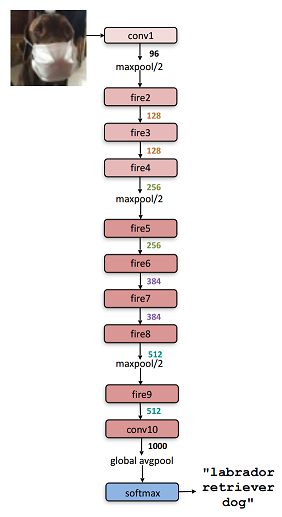

### Fire block 

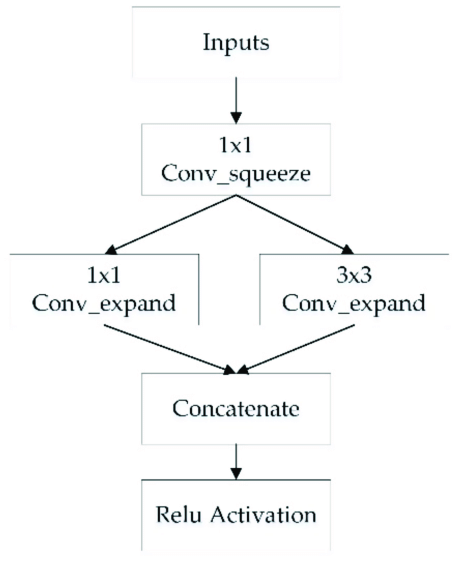

In [3]:
squeezenet = models.squeezenet1_0(pretrained=True).features

for param in squeezenet.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/jupyter/.torch/models/squeezenet1_0-a815701f.pth
5017600it [00:00, 9953079.99it/s]


In [4]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    
squeezenet.to(device)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace

## Load the images
* display the images
* apply the transformations: resize to tensor, and normalization of values.

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [6]:
def transformation(img):
    
    tasks = tf.Compose([tf.Resize(256), 
                        tf.ToTensor(),
                        tf.Normalize(mean, std)])
    
    img = tasks(img)  
    img = img.unsqueeze(0)    
    
    return img

In [7]:
content_img = Image.open("cat.jpg").convert('RGB')
style_img   = Image.open("starry_night.jpg").convert('RGB')

In [8]:
content_img = transformation(content_img).to(device)
style_img   = transformation(style_img).to(device)

In [9]:
content_img.shape

torch.Size([1, 3, 400, 400])

In [10]:
content_img

tensor([[[[ 1.1529,  1.1358,  1.1187,  ..., -0.2342, -0.2513, -0.2342],
          [ 1.1358,  1.1358,  1.1015,  ..., -0.3027, -0.3027, -0.3027],
          [ 1.1358,  1.1187,  1.1015,  ..., -0.3712, -0.3712, -0.3712],
          ...,
          [ 1.4269,  1.3927,  1.3927,  ...,  1.1529,  1.1700,  1.1529],
          [ 1.4269,  1.3755,  1.3755,  ...,  1.1529,  1.1529,  1.1358],
          [ 1.4098,  1.3927,  1.3755,  ...,  1.1529,  1.1358,  1.1358]],

         [[ 1.2381,  1.2381,  1.2381,  ...,  0.0301,  0.0301,  0.0126],
          [ 1.2381,  1.2381,  1.2206,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.2381,  1.2381,  1.2031,  ..., -0.0924, -0.0924, -0.0924],
          ...,
          [ 1.5357,  1.5357,  1.5357,  ...,  1.3081,  1.3081,  1.3081],
          [ 1.5357,  1.5357,  1.5182,  ...,  1.3081,  1.3081,  1.3081],
          [ 1.5532,  1.5357,  1.5182,  ...,  1.3081,  1.3081,  1.2906]],

         [[ 1.5768,  1.5594,  1.5594,  ...,  0.4091,  0.4091,  0.4091],
          [ 1.5594,  1.5594,  

In [11]:
style_img.shape

torch.Size([1, 3, 400, 500])

In [12]:
style_img

tensor([[[[-0.3883, -0.7822, -1.2445,  ..., -1.4843, -1.5528, -2.0837],
          [-0.3198, -0.5767, -0.9192,  ..., -1.2617, -1.8439, -2.1008],
          [-0.2513, -0.4568, -0.6794,  ..., -1.1589, -1.5699, -2.0837],
          ...,
          [-0.8678, -1.0390, -0.9363,  ..., -1.7069, -1.8439, -1.7069],
          [-1.1075, -1.5870, -1.5699,  ..., -1.5185, -1.6727, -1.6727],
          [-1.5357, -1.9467, -1.8610,  ..., -1.3130, -1.4500, -1.5699]],

         [[ 0.9055,  0.4153, -0.2150,  ..., -1.0378, -1.3529, -2.0182],
          [ 0.9930,  0.6254,  0.1176,  ..., -0.7052, -1.5980, -1.9832],
          [ 1.0455,  0.7479,  0.3627,  ..., -0.4776, -1.1604, -1.8782],
          ...,
          [-0.7752, -0.9503, -0.8452,  ..., -1.1954, -1.3354, -1.1954],
          [-1.0203, -1.5105, -1.4930,  ..., -1.0028, -1.1604, -1.1604],
          [-1.4580, -1.8782, -1.7906,  ..., -0.7927, -0.9328, -1.0553]],

         [[ 1.9080,  1.4548,  0.8797,  ..., -0.3055, -0.7761, -1.4733],
          [ 1.9951,  1.6640,  

### Define a method to convert tensors to images
* Clone the tensor
* Convert the tensor to a numpy array and squeeze it to make it 3d
* Transpose performs CHW -> HWC
* Normalize the image and clip the floats into the valid range for plotting

In [26]:
def tensor_to_image(tensor):

    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()
    
    image = image.transpose(1, 2, 0)
    
    image *= np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    
    return image

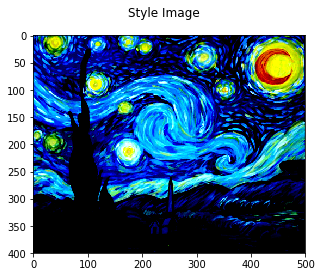

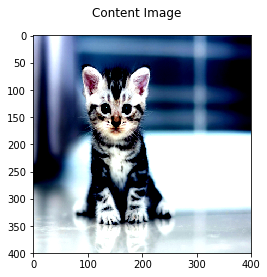

In [27]:
img = tensor_to_image(style_img)
fig = plt.figure()
fig.suptitle('Style Image')
plt.imshow(img)

img = tensor_to_image(content_img)
fig = plt.figure()
fig.suptitle('Content Image')
plt.imshow(img)

## Obtain features from the images
* We use all the initial convolutional layers to extract style information and layer conv7_1 for content information

In [28]:
LAYERS_OF_INTEREST = {'0': 'conv1_1', 
                      '3': 'conv2_1',  
                      '4': 'conv3_1',
                      '5': 'conv4_1',
                      '6': 'conv5_1',
                      '7': 'conv6_1',  
                      '8': 'conv7_1',
                      '9': 'conv8_1'}

In [29]:
def apply_model_and_extract_features(image, model):
    x = image

    features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x   
            
    return features

In [30]:
content_img_features = apply_model_and_extract_features(content_img, squeezenet)
style_img_features   = apply_model_and_extract_features(style_img, squeezenet)

In [31]:
content_img_features

{'conv1_1': tensor([[[[6.0522e-02, 6.7781e-02, 2.3547e-02,  ..., 6.0577e-03,
            1.2596e-04, 9.5084e-03],
           [5.4886e-02, 3.2754e-02, 4.2686e-02,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [4.4256e-02, 4.8848e-02, 5.3023e-02,  ..., 5.2995e-03,
            3.5895e-02, 2.3169e-02],
           ...,
           [5.6686e-02, 7.0666e-02, 2.9559e-02,  ..., 6.0408e-02,
            5.1622e-02, 3.2410e-02],
           [3.8038e-02, 1.7400e-02, 5.2876e-02,  ..., 2.7800e-02,
            2.2871e-02, 4.2020e-02],
           [4.0161e-02, 4.3351e-02, 7.5808e-02,  ..., 3.1295e-02,
            4.1415e-02, 2.8436e-02]],
 
          [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4766e-03,
            2.9405e-02, 3.3211e-02],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            1.2269e-02, 3.6995e-02],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3276e-02,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0

In [32]:
style_img_features

{'conv1_1': tensor([[[[1.3318, 0.0000, 1.8165,  ..., 0.0180, 0.0000, 0.8150],
           [1.6107, 0.0000, 0.7841,  ..., 0.4394, 0.2828, 0.0000],
           [0.5191, 0.0000, 1.0329,  ..., 0.0000, 0.4083, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0512, 0.0655],
           [0.0000, 0.0128, 0.0570,  ..., 0.0000, 0.1569, 0.0298],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.1516, 0.3324,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.4800, 0.6058,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 1.2759, 0.7160,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 1.5439, 0.5705, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.9810, 0.7542, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.2452, 0.3701, 0.1092]],
 
          [[1.5540, 1.4212, 0.7170,  ..., 0.0000, 0.1338, 0.6429],
           [0.0000, 0.0628, 0.0600,  ..., 0.7209, 0.0039, 0.0199],
           [0

Feature correlations are given by the Gram matrix G, where every cell (i, j) in G is the inner product between the vectorised feature maps i and j in a layer.

In [33]:
def calculate_gram_matrix(tensor):
    
    _, channels, height, width = tensor.size()
    
    tensor = tensor.view(channels, height * width)    
    
    gram_matrix = torch.mm(tensor, tensor.t())
    
    gram_matrix = gram_matrix.div(channels * height * width) 
    
    return gram_matrix

In [34]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in 
                                                    style_img_features}

style_features_gram_matrix

{'conv1_1': tensor([[7.3279e-04, 3.8113e-04, 3.7478e-04,  ..., 1.4034e-04, 7.2188e-04,
          1.5767e-03],
         [3.8113e-04, 4.8552e-03, 7.0725e-04,  ..., 2.1681e-04, 4.2211e-03,
          2.8642e-03],
         [3.7478e-04, 7.0725e-04, 3.3523e-03,  ..., 2.0293e-04, 1.8937e-03,
          4.1882e-03],
         ...,
         [1.4034e-04, 2.1681e-04, 2.0293e-04,  ..., 1.0320e-03, 4.1889e-04,
          1.4043e-05],
         [7.2188e-04, 4.2211e-03, 1.8937e-03,  ..., 4.1889e-04, 1.2649e-02,
          5.2651e-03],
         [1.5767e-03, 2.8642e-03, 4.1882e-03,  ..., 1.4043e-05, 5.2651e-03,
          2.5803e-02]], device='cuda:0'),
 'conv2_1': tensor([[6.0560e-03, 3.9729e-03, 3.6548e-03,  ..., 6.0807e-03, 1.9172e-04,
          1.3762e-02],
         [3.9729e-03, 9.2660e-02, 2.1624e-02,  ..., 1.2219e-02, 1.0468e-04,
          3.7367e-02],
         [3.6548e-03, 2.1624e-02, 4.7586e-02,  ..., 1.0981e-02, 1.2565e-04,
          3.0998e-02],
         ...,
         [6.0807e-03, 1.2219e-02, 1.0981

## Performing Style Transfer


In [35]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.65,
           'conv4_1': 0.5, 'conv5_1': 0.45, 'conv6_1': 0.3, 
           'conv7_1': 0.1, 'conv8_1': 0.15}

In [36]:
target = content_img.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.003)

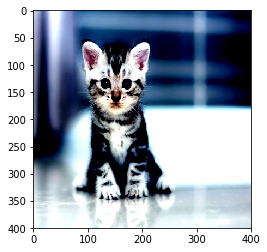

In [37]:
plt.figure()
plt.imshow(tensor_to_image(target))

### Start the loss minimization process 
* Run the loop for some large number of iterations. 
* Calculate the content loss (from content image and target) using mse
* Calculate the style loss (from style image and target) using mse
* The combined loss is then backpropagated and minimised.
* Using the minimized loss, the network parameters are updated which further updates the target image.

In [38]:
for i in range(1, 2000):
    
    target_features = apply_model_and_extract_features(target, squeezenet)
    
    content_loss = F.mse_loss (target_features['conv7_1'], content_img_features['conv7_1'])
    
    style_loss = 0
    for layer in weights:
        
        target_feature = target_features[layer]

        target_gram_matrix = calculate_gram_matrix(target_feature)

        style_gram_matrix = style_features_gram_matrix[layer]
        
        layer_loss = F.mse_loss (target_gram_matrix, style_gram_matrix)
        layer_loss *= weights[layer]
        
        _, channels, height, width = target_feature.shape

        style_loss += layer_loss  
    
    total_loss = 1000000 * style_loss + content_loss
    
    if i % 50 == 0:
        print ('Epoch {}:, Style Loss : {:4f}, Content Loss : {:4f}'.format( i, style_loss, content_loss))
    
    optimizer.zero_grad()
    
    total_loss.backward()
    
    optimizer.step()

Epoch 50:, Style Loss : 0.039848, Content Loss : 132.849167
Epoch 100:, Style Loss : 0.020941, Content Loss : 172.170792
Epoch 150:, Style Loss : 0.014479, Content Loss : 184.961594
Epoch 200:, Style Loss : 0.010807, Content Loss : 192.040924
Epoch 250:, Style Loss : 0.008457, Content Loss : 196.979935
Epoch 300:, Style Loss : 0.006840, Content Loss : 200.638794
Epoch 350:, Style Loss : 0.005677, Content Loss : 203.570511
Epoch 400:, Style Loss : 0.004812, Content Loss : 205.867447
Epoch 450:, Style Loss : 0.004142, Content Loss : 207.767532
Epoch 500:, Style Loss : 0.003610, Content Loss : 209.196747
Epoch 550:, Style Loss : 0.003177, Content Loss : 210.438217
Epoch 600:, Style Loss : 0.002823, Content Loss : 211.595062
Epoch 650:, Style Loss : 0.002525, Content Loss : 212.530212
Epoch 700:, Style Loss : 0.002274, Content Loss : 213.291199
Epoch 750:, Style Loss : 0.002059, Content Loss : 213.902374
Epoch 800:, Style Loss : 0.001873, Content Loss : 214.458817
Epoch 850:, Style Loss : 

## Plot Results

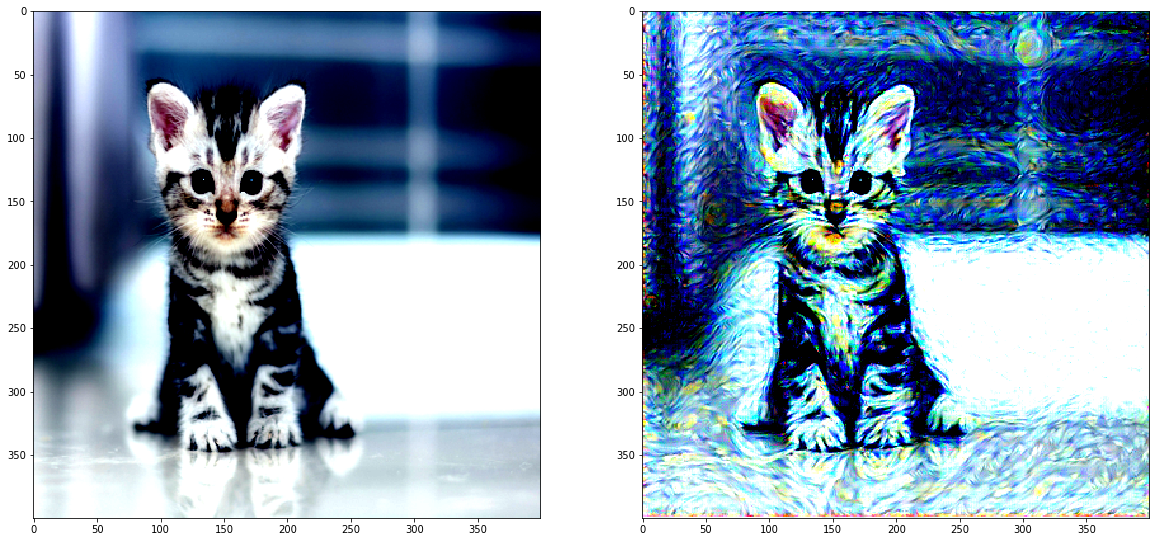

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))